In [1]:
import pandas as pd
import re
from copy import copy
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
import nltk
from nltk.collocations import *
from random import choice
import numpy as np
import matplotlib as plt
from wordcloud import WordCloud
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy', 'plt', 'choice']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# a, b

In [2]:
data = pd.read_csv('Emails.csv')
data.RawText = map(lambda s: s.split('\n'), data.RawText)
data.head()

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,"[UNCLASSIFIED, U.S. Department of State, Case ..."
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...","[UNCLASSIFIED, U.S. Department of State, Case ..."
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,"[UNCLASSIFIED, U.S. Department of State, Case ..."
3,4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,"[UNCLASSIFIED, U.S. Department of State, Case ..."
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...","[B6, UNCLASSIFIED, U.S. Department of State, C..."


Посмотрим, какие есть поля.

In [3]:
data.columns

Index([u'Id', u'DocNumber', u'MetadataSubject', u'MetadataTo', u'MetadataFrom',
       u'SenderPersonId', u'MetadataDateSent', u'MetadataDateReleased',
       u'MetadataPdfLink', u'MetadataCaseNumber', u'MetadataDocumentClass',
       u'ExtractedSubject', u'ExtractedTo', u'ExtractedFrom', u'ExtractedCc',
       u'ExtractedDateSent', u'ExtractedCaseNumber', u'ExtractedDocNumber',
       u'ExtractedDateReleased', u'ExtractedReleaseInPartOrFull',
       u'ExtractedBodyText', u'RawText'],
      dtype='object')

# c

Решила оставить тему, id sender, дату, и текст письма - эти поля мне кажутся наиболее информативными.

In [4]:
data_to_analyze = data[['MetadataSubject', 'SenderPersonId', 'MetadataDateSent', 'ExtractedBodyText']].dropna()

In [5]:
texts = copy(data.RawText)

Так как поле текста письма содержит много мусора, попробуем удалить все лишнее.

In [6]:
weeks_days =  '|'.join(['Monday' , 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
months = '|'.join(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September',
               'October', 'November', 'December'])
time = '[0-9]{1,2}, 20[0-9]{2} [0-9]{1,2}:[0-9]{2} AM'
time2 = '[0-9]{1,2}, 20[0-9]{2} [0-9]{1,2}:[0-9]{2} PM'
date = '[0-9]{2}/[0-9]{2}/[0-9]{4}'
number = 'No. [A-Z][0-9,-]*'
# date_pattern =  '[' + weeks_days + '], [' + months + '] [0-9]{1,2}, 20[0-9]{2} [0-9]{1,2}:[0-9]{2} PM'

In [7]:
def does_not_contain_trash(phrase, trash = {'Case', 'From', 'To', 'UNCLASSIFIED', 
                                            'Sent', 'Date', 'Doc', 'U.S. Department',
                                           'STATE DEPT', 'SUBJECT TO', 'RELEASE', '\x0c',
                                            'March', 'January', 'February', 'April', 'May',
                                           'June', 'July', 'August', 'September', 'October',
                                           'November', 'December', 'Cc', 'Monday', 'Tuesday', 
                                           'Wednesday', 'Thursday', 'Friday', 'Saturday', 
                                            'Sunday', 'Re', 'cc'}):
    for tr in trash:
        if phrase.startswith(tr):
            return False
    
    return True

In [8]:
def delete_trash(phrase, trash_patterns = {'Subject:', 'Subject', 'Case', 'From', 'To', 'UNCLASSIFIED',
                                            'Sent:', 'Date', 'Doc', 'U.S. Department',
                                           'STATE DEPT', 'SUBJECT TO', 'RELEASE', '\x0c', 'Fw:',
                                            'Cc',  'Re', 'cc', '\<(.*?)\>', 'H',
                                           '\n\n', number, ':{\s}{>0}\n', ',{\s}{>1}', '{\s}{>1}', '{\n}{>1}', 
                                          time2}):
    
    for tr in trash_patterns:
        phrase = re.sub(tr, '', phrase)
    
    return phrase

In [9]:
def not_space(phrase):
    return phrase != ' ' and phrase != ''

In [10]:
texts = map(lambda s: filter(does_not_contain_trash, s), data.RawText)
texts = map(lambda s: filter(not_space, s), texts)
texts = map(lambda s: map(lambda t: delete_trash(t), s), texts)
texts = map(lambda s: ' '.join(s), texts)

In [11]:
data_to_analyze.ExtractedBodyText = data_to_analyze.ExtractedBodyText.apply(delete_trash)

Посмотрим на результат.

In [12]:
for i in range(100, 110):
    index = choice(data_to_analyze.index)
    print choice(texts)
    print '----------------------------------------------------------'

B6  MS -- Valmoro, Lona.)   Thank you! I hope the craziness of UNGA is going well -- thank you again! All the best, Lona
----------------------------------------------------------
 sbwhoeop  fyi: ague report and DeMint... Sid : ere's the Guardian aount of ague's post-meeting press briefing. And below that the article on DeMint. S William ague addresses US fears over ries' EU allies •illary Clinton 'told antisemitism allegations are a smear' •Shadow foreign secretary opposes ny Blair as EU leader • Ewen MacAskill in Washington and Nicholas Watt • quardian.co.uk, Thursday 22 October 2009 00.33 BST William ague, the shadow foreign secretary, yesterday defended the Conservatives' alliance with far-right parties in Europe during a meeting in Washington with the US secretary of state, illary Clinton. ague sought to reassure Clinton about the Conservatives' partners, some of whose members have taken part in commemoration services for the Waffen-SS in Latvia and questioned the need to apologis

# d

Найдем самую часто встречающуюся биграмму:

In [12]:
vectorizer = CountVectorizer(ngram_range=(2,2))
corpus = vectorizer.fit_transform(data_to_analyze.ExtractedBodyText)
sum_biwords = np.array(corpus.sum(axis=0))[0]
sum_biwords.argmax()

147257

In [146]:
filter(lambda s: vectorizer.vocabulary_[s] == sum_biwords.argmax(), vectorizer.vocabulary_.keys())

[u'of the']

'of the' - кажется вполне адекватным.

# e

In [149]:
finder = BigramCollocationFinder.from_words(toke)
finder.nbest(bigram_measures.pmi, 10)

In [163]:
finder = BigramCollocationFinder.from_words(nltk.tokenize.word_tokenize(data_to_analyze.ExtractedBodyText.to_string()),
                                            window_size = 20)

In [164]:
finder.nbest(bigram_measures.pmi, 5)

[(u"'D", u'1059'),
 (u"'D", u'1060'),
 (u"'D", u'1061'),
 (u"'D", u'Isabelle\u2014just'),
 (u"'D", u'Schedule\\nJoe-')]

## f

In [13]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE

In [14]:
vectorizer = TfidfVectorizer(max_features=2000)
corpus = vectorizer.fit_transform(data_to_analyze.ExtractedBodyText)

In [15]:
num_classes = 3
clasterizer = KMeans(n_clusters=num_classes)
%time y = clasterizer.fit_predict(corpus)

CPU times: user 16.7 s, sys: 16 ms, total: 16.7 s
Wall time: 16.7 s


In [16]:
tsne = TSNE()
X_tsne = tsne.fit_transform(corpus.todense())

In [17]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(corpus.todense())

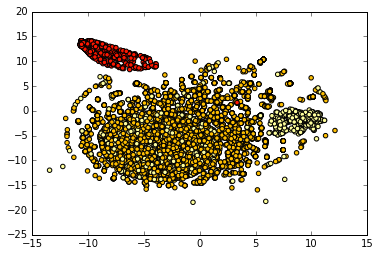

In [18]:
color_dict = cm.hot(np.linspace(0.4, 0.9, num_classes))
plt.figure()
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=color_dict[y])
plt.show()

# f, h

In [19]:
index_to_word = dict()

for word, index in vectorizer.vocabulary_.iteritems():
    index_to_word[index] = word

In [21]:
top_classes_words = list()
nearest_to_centr = list()
top_k = 60
top_words_scores = dict()

for i in range(num_classes):
    top_classes_words.append(set())
    class_corpus = corpus[np.where(y == i)]
    class_mean = np.array(class_corpus.mean(axis=0))[0]
    
    nearest_neighbour_index = np.argmin(np.power(corpus - class_mean, 2).sum(axis=1))
    nearest_to_centr.append(nearest_neighbour_index)
    
    top_k_scores = sorted(class_mean)[-top_k:]
    top_k_indecies = filter(lambda i: class_mean[i] in top_k_scores, range(class_mean.shape[0]))

    #print class_id, len(top_k_indecies)
    if len(top_k_indecies) > top_k:
        top_k_indecies = list(set(choice(top_k_indecies, size=top_k)))
    
    for index in top_k_indecies:
        top_classes_words[-1].add(index_to_word[index])
        top_words_scores[index_to_word[index]] = class_mean[index]

top_classes_words2 = copy(top_classes_words)
#lens = map(len, top_classes_words)
#print lens

for i in range(num_classes):
    other_classes_words = set()
    
    if top_classes_words2[:i] != []:
        other_classes_words = other_classes_words.union(*top_classes_words2[:i])
    
    if not top_classes_words2[i+1:] != []:
        other_classes_words = other_classes_words.union(*top_classes_words2[i+1:])

    top_classes_words[i] = top_classes_words[i].difference(other_classes_words)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:35: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:32: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


In [22]:
def create_frequency_string(word_voc, frequency_dict=top_words_scores):
    string_ = ''
    for word in word_voc:
        word_fr = ' '.join([word] * max(int(top_words_scores[word] * 100), 1))
        string_ = string_ + ' ' + word_fr
    return string_ 

In [23]:
eps=0.1
centres = np.array([X_tsne[np.where(y == 0)].mean(axis=0), X_tsne[np.where(y == 1)].mean(axis=0),
                   X_tsne[np.where(y == 2)].mean(axis=0)])
X_tsne_to_show = (X_tsne - np.min(X_tsne, axis=0) + eps) / (np.max(X_tsne, axis=0)- 3 * eps)
centres = (centres - np.min(X_tsne, axis=0) + eps) / (np.max(X_tsne, axis=0))

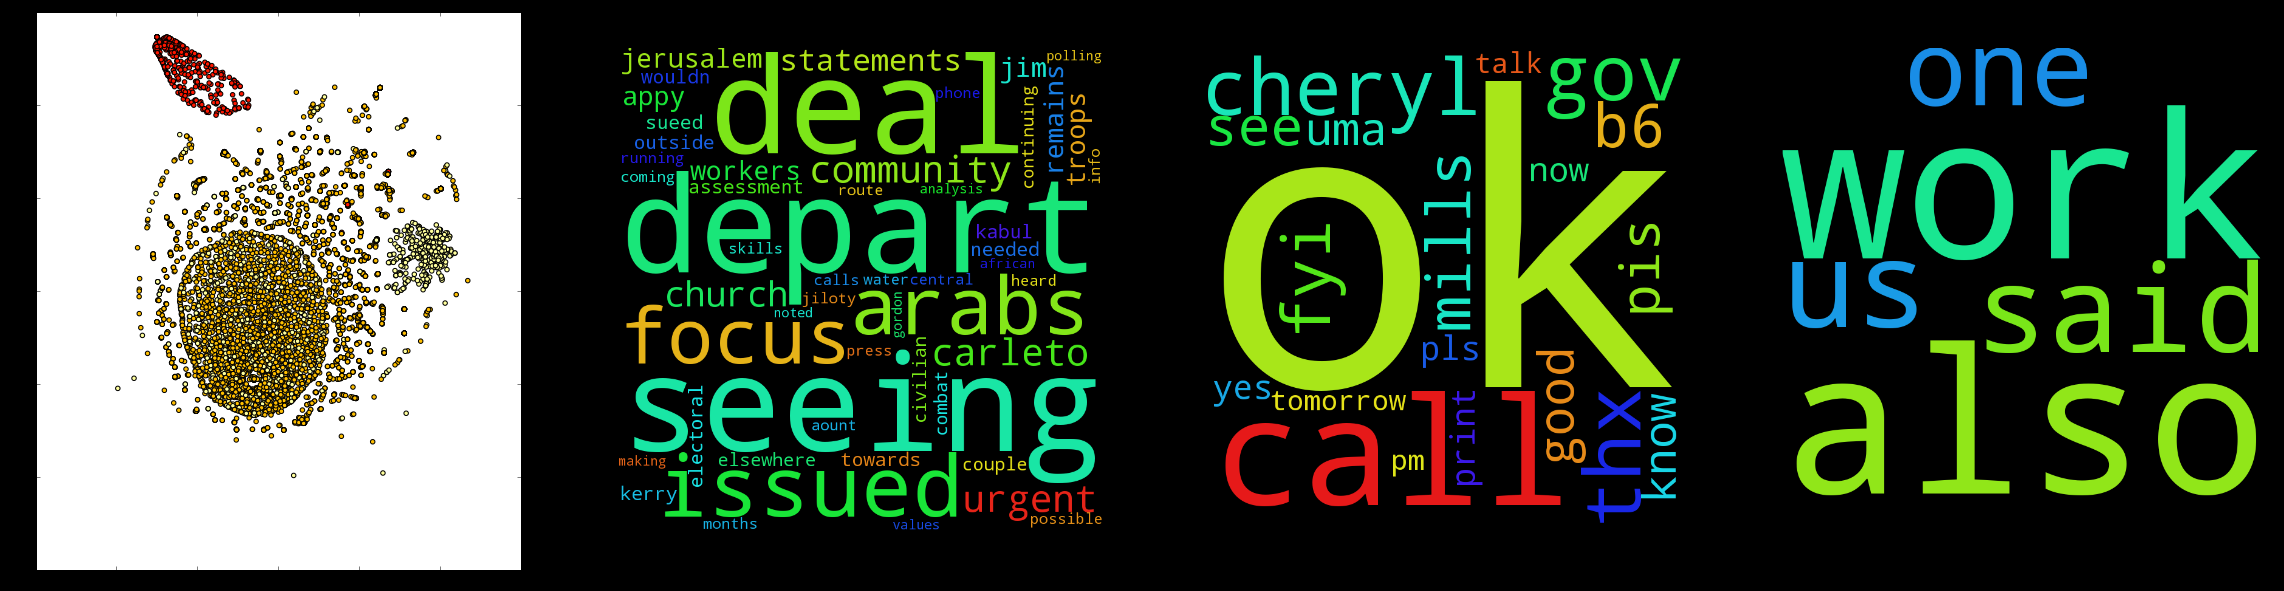

In [40]:
fig = plt.figure(figsize=(40, 10))
fig.add_subplot(1,num_classes+1,1)
plt.scatter(X_tsne_to_show[:,0], X_tsne_to_show[:, 1], c=color_dict[y])
img_size = 800

for class_id in range(num_classes):
    class_words_fr_str = create_frequency_string(top_classes_words[class_id], top_words_scores)
    wcloud = WordCloud(height=img_size, width=img_size, relative_scaling=0.8,
                        prefer_horizontal=0.9)
    wcloud.generate(class_words_fr_str)
    ax = plt.subplot(1,num_classes+1,class_id+2)
    ax.imshow(wcloud)
    ax.axis('off')
fig.patch.set_facecolor('black')
plt.draw()
plt.show()